# ===========================================================
# Implement basic dynamic models to estimate influence matrices
# ===========================================================

## Goals:
####   1. Analyze at the dynamics of the influence matrices
####   2. Implement Structurl Balance Theory and etc. models to estimate influence matrices in the jeopardy dataset

#### Last update: 17 Jan 2020

# Imports

In [376]:
from __future__ import division, print_function, absolute_import, unicode_literals

import pdb
import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import imp
from collections import defaultdict
import sys
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
import pogs_jeopardy_log_lib
import mytools

In [154]:
def reload():
    imp.reload(mytools)
    imp.reload(utils)
    imp.reload(pogs_jeopardy_log_lib)

# Parameters

In [371]:
directory = '/home/omid/Datasets/Jeopardy/'

# Helper functions

# Loading teams' logs

In [7]:
data = utils.load_it(directory+'Teams_logs.pk')

In [8]:
len(data)

49

# Dynamics of influence matrices

In [9]:
frob_norm_of_consecutive = defaultdict(list)
for team_id, team_log in data.items():
    for index in range(1, len(team_log.member_influences)):
        diff = np.matrix(team_log.member_influences[index]) / 100 - np.matrix(team_log.member_influences[index - 1]) / 100
        frob_norm_of_consecutive[team_id].append(
            np.linalg.norm(diff, ord=2))
#             (np.square(diff)).mean(axis=None))

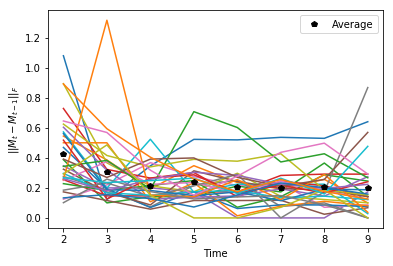

In [360]:
f = plt.figure()
team_diffs = np.zeros(8)
cnt = 0
for team_id, team_diff in frob_norm_of_consecutive.items():
    if len(team_diff) == 8:
        team_diffs += team_diff
        cnt += 1
        plt.plot(np.arange(2, 10), team_diff)
team_diffs /= cnt
# plt.title('Consecutive Frobenius norm difference of influence matrix in every team')
plt.xlabel('Time')
plt.ylabel('$||M_t - M_{t-1}||_F$')
plt.plot(np.arange(2, 10), team_diffs, 'p', color='black', label='Average')
plt.legend()
f.savefig('consecutive_frob_norm_of_influence_matrices.pdf', bbox_inches='tight')
f.savefig('consecutive_frob_norm_of_influence_matrices.png', bbox_inches='tight')

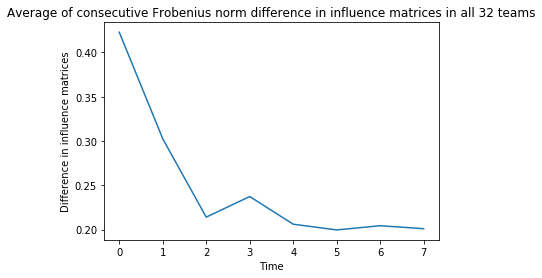

In [11]:
plt.plot(team_diffs);
plt.title('Average of consecutive Frobenius norm difference in influence matrices in all {} teams'.format(cnt))
plt.xlabel('Time')
plt.ylabel('Difference in influence matrices');

#### And its relationship with performance

In [14]:
c = 0
sig_c = 0
for team_id, team_log in data.items():
    if team_id in frob_norm_of_consecutive and 45 in team_log.accumulated_score:
        c += 1
        this_team_diff = frob_norm_of_consecutive[team_id]
        this_team_perf = [team_log.accumulated_score[index] for index in [10, 15, 20, 25, 30, 35, 40, 45]]
        r_val, p_val = sp.stats.pearsonr(this_team_diff, this_team_perf)
        if p_val < 0.05:
            print(r_val, p_val)
            sig_c += 1
#         utils.compute_relationship(this_team_diff, this_team_perf, maxlag=1)

-0.7680855906773422 0.02601105129486113
-0.7135011778509429 0.046881934464170175
-0.7290727743407934 0.04016148582204802
-0.722060360320318 0.043110083288295804
-0.7173505678181669 0.045161927009208735
-0.7594052826922197 0.02883718158099217
-0.7873209221948606 0.02037694101689579
-0.7217222048396326 0.043255481271374005
-0.7462265759731526 0.03347629015421849
-0.9354677888207427 0.0006397487651953237


In [15]:
print('Only {:.2f}% were statistically significant.'.format(100 * sig_c / c))

Only 32.26% were statistically significant.


# Looking at their possible binary TMS (the question by Francesco)

It means people only look at their own perf and others and do not care about every other individual. It means they rescale their influence with respect to all not individuals

In [382]:
all_influence_matrices = []
for team_id, team_log in data.items():
    influence_matrices = []
    for t in range(len(team_log.member_influences)):
        influence_matrix = utils.make_matrix_row_stochastic(
            np.array(team_log.member_influences[t]) / 100)
        influence_matrices.append(influence_matrix)
    all_influence_matrices.append(influence_matrices)

In [476]:
aa = 0
for influence_matrices in all_influence_matrices:
    aa += len(influence_matrices) - 1
print(aa)

290


In [463]:
all_predicteds = []
for influence_matrices in all_influence_matrices:
    predicteds = []
    for t in range(1, len(influence_matrices)):
        err = 0
        prev = influence_matrices[t - 1]
        curr = influence_matrices[t]
        predicted = np.zeros((4, 4))
        for i in range(4):
            predicted[i, i] = curr[i, i]
            s = 0
            for j in range(4):
                if i != j:
                    s += prev[i, j]
            if s != 0:
                for j in range(4):
                    if i != j:
                        predicted[i, j] = prev[i, j] * ((1 - curr[i, i]) / s)
            else:
                predicted[i, j] = (1 - curr[i, i]) / 3
        predicteds.append(predicted)
    all_predicteds.append(predicteds)

In [506]:
# errors = []
exact_match_counter = 0
same_order_counter = 0
all_counter = 0
for i in range(len(all_influence_matrices)):
    real_influence_matrices = all_influence_matrices[i]
    predicted_influence_matrices = all_predicteds[i]
    for t in range(1, len(real_influence_matrices)):
        true_matrix = real_influence_matrices[t]
        pred_matrix = predicted_influence_matrices[t - 1]
        for i in range(4):
            if np.sum(abs(true_matrix[i, :] - pred_matrix[i, :])) == 0:
                exact_match_counter += 1
            others_indices = list(set(np.arange(4)) - set([i]))
            if all(np.argsort(
                true_matrix[i, others_indices]) == np.argsort(
                    pred_matrix[i, others_indices])):
                same_order_counter += 1
            all_counter += 1
#         errors.append(
#             utils.matrix_estimation_error(
#                 true_matrix, pred_matrix, type_str='mse'))

In [520]:
print(
    'Result:\nFor every row in the next influence matrix without diagonal entries, '
    'for every individual, if we simply rescale previous influence given to '
    'others by him or her, then =>\nOut of {} influence distributions (rows in matrices), '
    'exactly {}% of all of which were exact match. Also {}% of all had the same order.'.format(
        all_counter, exact_match_counter / all_counter, same_order_counter / all_counter))

Result:
For every row in the next influence matrix without diagonal entries, for every individual, if we simply rescale previous influence given to others by him or her, then =>
Out of 1172 influence distributions (rows in matrices), exactly 0.4121160409556314% of all of which were exact match. Also 0.6467576791808873% of all had the same order.


# Dynamic models: SBT, Mei's

## SBT

In [ ]:
# def ven_de_rijt_sbt(influence_matrix, mode = 1):
#     n, m = influence_matrix.shape
#     if n != m:
#         raise ValueError('The matrix was not squared.')
#     next_influence_matrix = np.zeros(influence_matrix.shape)
#     for i in range(n):
#         for j in range(n):
#             if i != j:
#                 ks = list(set.difference(set(range(n)), [i, j]))
#                 wij = 0
#                 for k in ks:
#                     wij += influence_matrix[i, k] * influence_matrix[k, j] 
# #                 wij /= (n - 2)
#                 next_influence_matrix[i, j] = wij

#     if mode == 1:
#         # Fill the diagonal with previous influence matrix and normalize to become row-stochastic.
#         np.fill_diagonal(next_influence_matrix, np.diag(influence_matrix))
#         next_influence_matrix = utils.make_matrix_row_stochastic(
#             next_influence_matrix)
#     elif mode == 2:
#         # Fill the diagonal with 1 - sum of the current filled row.
#         np.fill_diagonal(next_influence_matrix, 1 - np.sum(next_influence_matrix, axis=1))
#     else:
#         print('ERROR: mode was wrong. It was {}'.format(mode))
    
#     return next_influence_matrix

In [135]:
cnt = 0
mean_influence_matrix = np.zeros((4, 4))
all_influence_matrices = []
for team_id, team_log in data.items():
    if len(team_log.member_influences) < 9 or np.sum(team_log.member_influences_from_data[-1]) != 16:
        continue
    influence_matrices = []
    for inf_matrix in team_log.member_influences:
        influence_matrix = utils.make_matrix_row_stochastic(
            np.matrix(inf_matrix) / 100)
        influence_matrices.append(influence_matrix)
        mean_influence_matrix += influence_matrix
        cnt += 1
    all_influence_matrices.append(influence_matrices)
mean_influence_matrix /= cnt

## Mei's model

In [320]:
# Computing individual performances right before reporting the influence matrix.
hardness_weights = {
    pogs_jeopardy_log_lib.Level.EASY: 1,
    pogs_jeopardy_log_lib.Level.MEDIUM: 2,
    pogs_jeopardy_log_lib.Level.HARD: 3}

questions = data[37].game_info.questions
questions_order = data[37].question_order
individual_performances = {}
perf = {}
for team_id, team_log in data.items():
    perf[team_id] = defaultdict(
        lambda: {'#correct': 0,
                 '#questions': 0,
                 '#hardness_weighted_correct': 0,
                 '#hardness_weighted_questions': 0})
    individual_performances[team_id] = defaultdict(list)
    for qnum, qid in enumerate(questions_order):
        if qid in team_log.individual_answers_chosen:
            team_answers = team_log.individual_answers_chosen[qid]
            hardness_weight = hardness_weights[questions[qid].level]
            for member in team_log.members:
                if member in team_answers:
                    perf[team_id][member]['#questions'] += 1
                    perf[team_id][member]['#hardness_weighted_questions'] += hardness_weight
                    if questions[qid].answer == team_answers[member]:
                        perf[team_id][member]['#correct'] += 1
                        perf[team_id][member]['#hardness_weighted_correct'] += hardness_weight
        if (qnum + 1) % 5 == 0:
            for member in team_log.members:
                this_member_correct_rate = perf[team_id][member]['#correct'] / perf[team_id][member]['#questions']
#                 this_member_hardness_weighted_correct_rate = perf[team_id][member]['#hardness_weighted_correct'] / perf[team_id][member]['#hardness_weighted_questions']
                individual_performances[team_id][member].append(this_member_correct_rate)

In [ ]:
# RUNS = 10
# error_type_str = 'mse'
# sbt_mode = 1

# all_random_errors = []
# all_uniform_errors = []
# all_average_errors = []
# all_mei_errors = []
# all_sbt_errors = []
# all_last_errors = []

# for run in range(RUNS):
#     random_errors = []
#     uniform_errors = []
#     average_errors = []
#     mei_errors = []
#     sbt_errors = []
#     last_errors = []
#     for team_id, individual_performance in individual_performances.items():
#         team_log = data[team_id]
#         for t in range(len(team_log.member_influences) - 1):
#             influence_matrix = utils.make_matrix_row_stochastic(
#                 np.array(team_log.member_influences[t]) / 100)
#             next_influence_matrix_real = utils.make_matrix_row_stochastic(
#                 np.array(team_log.member_influences[t + 1]) / 100)
#             # Putting the performance of members in the same order as the influence matrices.
#             ps = []
#             for member in team_log.members:
#                 ps.append(individual_performance[member][t])
#             p_minus_Mp = np.diag(
#                 [ps[0] - (ps[1] + ps[2] + ps[3]) / 3,
#                  ps[1] - (ps[0] + ps[2] + ps[3]) / 3,
#                  ps[2] - (ps[0] + ps[1] + ps[3]) / 3,
#                  ps[3] - (ps[0] + ps[1] + ps[2]) / 3])
#             A_dot = (
#                 p_minus_Mp * np.diag(np.diag(influence_matrix)) * (np.eye(4, 4) - influence_matrix)) / (
#                 np.sum(ps))
#             mei_next_influence_matrix_predicted = influence_matrix + A_dot
#     #         mei_next_influence_matrix_predicted = utils.make_matrix_row_stochastic(
#     #             mei_next_influence_matrix_predicted)
#             mei_err = utils.matrix_estimation_error(
#                 next_influence_matrix_real, mei_next_influence_matrix_predicted, type_str=error_type_str)
#             mei_errors.append(mei_err)

#             uniform_errors.append(utils.matrix_estimation_error(
#                 next_influence_matrix_real, np.ones((4, 4)) * 0.25, type_str=error_type_str))

#             average_errors.append(utils.matrix_estimation_error(
#                 next_influence_matrix_real, mean_influence_matrix, type_str=error_type_str))

#             pred_next_matrix = ven_de_rijt_sbt(influence_matrix, mode=sbt_mode)
#             sbt_err = utils.matrix_estimation_error(
#                 next_influence_matrix_real, pred_next_matrix, type_str=error_type_str)
#             sbt_errors.append(sbt_err)

#             # Random model prediction:
#             rand_err = utils.matrix_estimation_error(
#                 next_influence_matrix_real, utils.make_matrix_row_stochastic(
#                     np.random.rand(4, 4)), type_str=error_type_str)
#             random_errors.append(rand_err)

#             # Last:
#             last_err = utils.matrix_estimation_error(next_influence_matrix_real, influence_matrix)
#             last_errors.append(last_err)
            
#     all_random_errors.append(np.mean(random_errors))
#     all_uniform_errors.append(np.mean(uniform_errors))
#     all_average_errors.append(np.mean(average_errors))
#     all_mei_errors.append(np.mean(mei_errors))
#     all_last_errors.append(np.mean(last_errors))

array([ 0.0375, -0.0625,  0.0375, -0.0125])

In [529]:
error_type_str = 'mse'
sbt_mode = 1

random_errors = []
uniform_errors = []
average_errors = []
mei_errors = []
sbt_errors = []
last_errors = []
for team_id, individual_performance in individual_performances.items():
    team_log = data[team_id]
    for t in range(len(team_log.member_influences) - 1):
        influence_matrix = utils.make_matrix_row_stochastic(
            np.array(team_log.member_influences[t]) / 100)
        next_influence_matrix_real = utils.make_matrix_row_stochastic(
            np.array(team_log.member_influences[t + 1]) / 100)
        # Putting the performance of members in the same order as the influence matrices.
        ps = []
        for member in team_log.members:
            ps.append(individual_performance[member][t])
        
#         # From average of others:
#         p_minus_Mp = np.diag(
#             [ps[0] - (ps[1] + ps[2] + ps[3]) / 3,
#              ps[1] - (ps[0] + ps[2] + ps[3]) / 3,
#              ps[2] - (ps[0] + ps[1] + ps[3]) / 3,
#              ps[3] - (ps[0] + ps[1] + ps[2]) / 3])
        
        # From average of all:
        p_minus_Mp = np.diag(ps - np.sum(ps) / 4)

        A_dot = (
            p_minus_Mp * np.diag(np.diag(influence_matrix)) * (np.eye(4, 4) - influence_matrix)) / (
            np.sum(ps))
        mei_next_influence_matrix_predicted = influence_matrix + A_dot
#         mei_next_influence_matrix_predicted = utils.make_matrix_row_stochastic(
#             mei_next_influence_matrix_predicted)
        mei_err = utils.matrix_estimation_error(
            next_influence_matrix_real, mei_next_influence_matrix_predicted, type_str=error_type_str)
        mei_errors.append(mei_err)

        uniform_errors.append(utils.matrix_estimation_error(
            next_influence_matrix_real, np.ones((4, 4)) * 0.25, type_str=error_type_str))
        
        average_errors.append(utils.matrix_estimation_error(
            next_influence_matrix_real, mean_influence_matrix, type_str=error_type_str))
        
        pred_next_matrix = ven_de_rijt_sbt(influence_matrix, mode=sbt_mode)
        sbt_err = utils.matrix_estimation_error(
            next_influence_matrix_real, pred_next_matrix, type_str=error_type_str)
        sbt_errors.append(sbt_err)
        
        # Random model prediction:
        rand_err = utils.matrix_estimation_error(
            next_influence_matrix_real, utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)), type_str=error_type_str)
        random_errors.append(rand_err)
        
        # Last:
        last_err = utils.matrix_estimation_error(next_influence_matrix_real, influence_matrix)
        last_errors.append(last_err)

Mei's: 0.006573223286526493 +- 0.010920828037748812
Uniform: 0.012643031224390035 +- 0.013281079068406684
Average: 0.0119561758029185 +- 0.011994640886979128
SBT: 0.020203093472782287 +- 0.014042729123765082
Random: 0.032768809071880005 +- 0.01707167389120818
Last: 0.23930105912936736 +- 0.1521636104367098


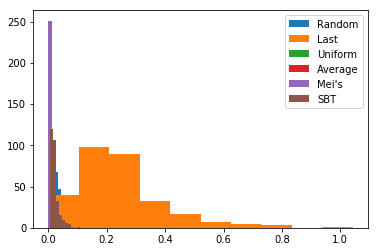

In [530]:
plt.hist(random_errors)
plt.hist(last_errors)
plt.hist(uniform_errors)
plt.hist(average_errors)
plt.hist(mei_errors)
plt.hist(sbt_errors)
plt.legend(['Random', 'Last', 'Uniform', 'Average', 'Mei\'s', 'SBT'])

print('Mei\'s: {} +- {}'.format(np.mean(mei_errors), np.std(mei_errors)))
print('Uniform: {} +- {}'.format(np.mean(uniform_errors), np.std(uniform_errors)))
print('Average: {} +- {}'.format(np.mean(average_errors), np.std(average_errors)))
print('SBT: {} +- {}'.format(np.mean(sbt_errors), np.std(sbt_errors)))
print('Random: {} +- {}'.format(np.mean(random_errors), np.std(random_errors)))
print('Last: {} +- {}'.format(np.mean(last_errors), np.std(last_errors)));